In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [2]:
import os

data_path = "/kaggle/input/brain-tumor-mri-dataset"
for folder in os.listdir(data_path):
    print(folder, ":", os.listdir(os.path.join(data_path, folder))[:5])


Training : ['pituitary', 'notumor', 'meningioma', 'glioma']
Testing : ['pituitary', 'notumor', 'meningioma', 'glioma']


#Importing Libraries

In [3]:
pip install tensorflow

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import shutil

In [5]:
data = "/kaggle/input/brain-tumor-mri-dataset"

In [6]:
base_dir = '/content/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create output directories
for split_dir in [train_dir, validation_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Categories from your dataset
categories = ['pituitary', 'notumor', 'meningioma', 'glioma']

# Split ratios
train_ratio = 0.8
validation_ratio = 0.2
test_ratio = 1 # This is not used in the current split logic, as train and val are taken from "Training" and test from "Testing"

# Split and copy
for category in categories:
    train_category_path = os.path.join(data, 'Training', category)
    test_category_path = os.path.join(data, 'Testing', category)

    # Process training and validation data
    if os.path.exists(train_category_path):
        image_files = os.listdir(train_category_path)
        np.random.shuffle(image_files)

        num_images = len(image_files)
        num_train = int(train_ratio * num_images)
        num_val = int(validation_ratio * num_images)

        train_files = image_files[:num_train]
        val_files = image_files[num_train:num_train + num_val]

        # Copy helper
        def copy_files(file_list, src_dir, dest_dir):
            dest_category_dir = os.path.join(dest_dir, category)
            os.makedirs(dest_category_dir, exist_ok=True)
            for file in file_list:
                src_path = os.path.join(src_dir, file)
                dst_path = os.path.join(dest_category_dir, file)
                shutil.copy(src_path, dst_path)

        copy_files(train_files, train_category_path, train_dir)
        copy_files(val_files, train_category_path, validation_dir)
    else:
       print(f"Training directory not found for category: {category}")

    # Process test data
    if os.path.exists(test_category_path):
        test_files = os.listdir(test_category_path)
        copy_files(test_files, test_category_path, test_dir)
    else:
        print(f"Testing directory not found for category: {category}")

print("Data split completed!")

Data split completed!


In [7]:
datagen = ImageDataGenerator(rescale=1./255)


train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 4568 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


#Using a simple CNN model

In [8]:
tf.keras.backend.clear_session()

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')


])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
tf.keras.backend.clear_session()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,748,996 (10.49 MB)

 Trainable params: 2,748,996 (10.49 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [13]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.4798 - loss: 1.1101 - val_accuracy: 0.7756 - val_loss: 0.6121
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.7670 - loss: 0.6169 - val_accuracy: 0.8160 - val_loss: 0.5245
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8068 - loss: 0.5026 - val_accuracy: 0.8519 - val_loss: 0.4116
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8550 - loss: 0.4204 - val_accuracy: 0.8633 - val_loss: 0.3817
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8631 - loss: 0.3758 - val_accuracy: 0.8869 - val_loss: 0.3222
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9007 - loss: 0.2957 - val_accuracy: 0.8703 - val_loss: 0.3433
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9060 - loss: 0.2649 - val_accuracy: 0.8791 - val_loss: 0.3515
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9094 - loss: 0.2439 - val_accuracy: 0

In [14]:
loss , accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9305 - loss: 0.2760
Test Loss: 0.1872
Test Accuracy: 95.35%


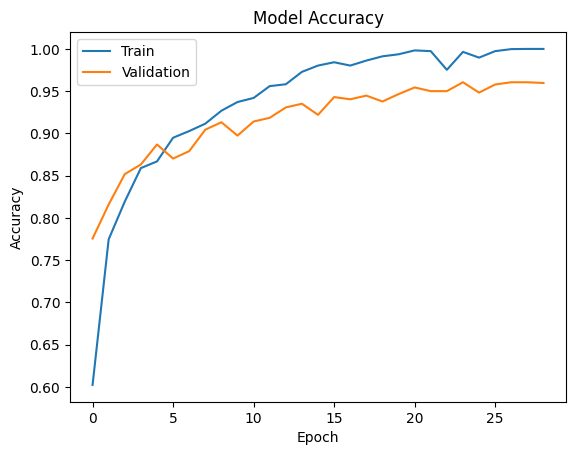

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

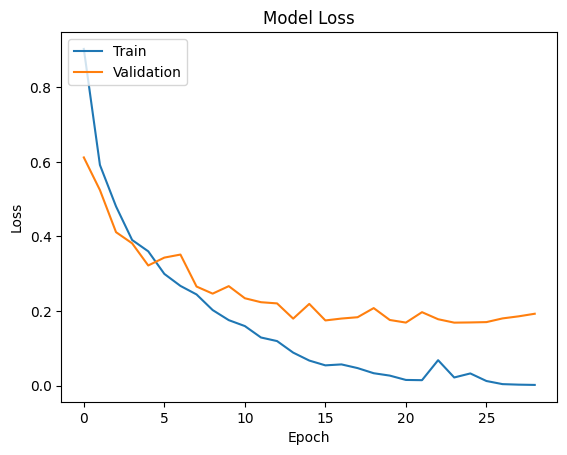

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
Classification Report:
               precision    recall  f1-score   support

   pituitary       0.94      0.92      0.93       300
     notumor       0.92      0.90      0.91       306
  meningioma       0.98      0.99      0.99       405
      glioma       0.96      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311

Confusion Matrix:
 [[277  19   0   4]
 [ 17 274   8   7]
 [  0   3 402   0]
 [  1   2   0 297]]


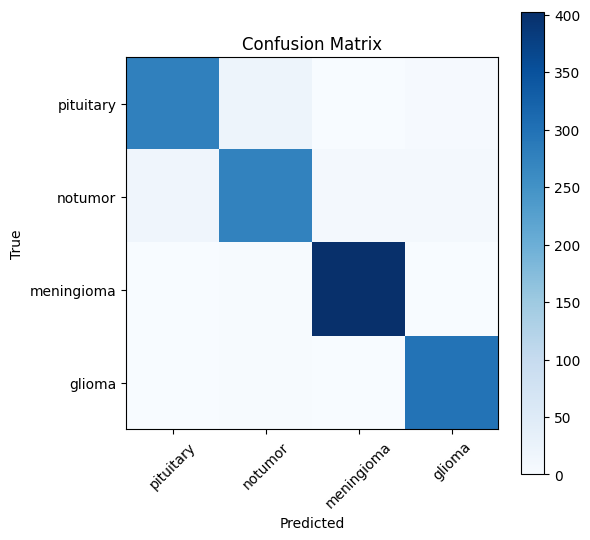

In [17]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=categories))

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(categories)), categories, rotation=45)
plt.yticks(np.arange(len(categories)), categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [19]:
import cv2

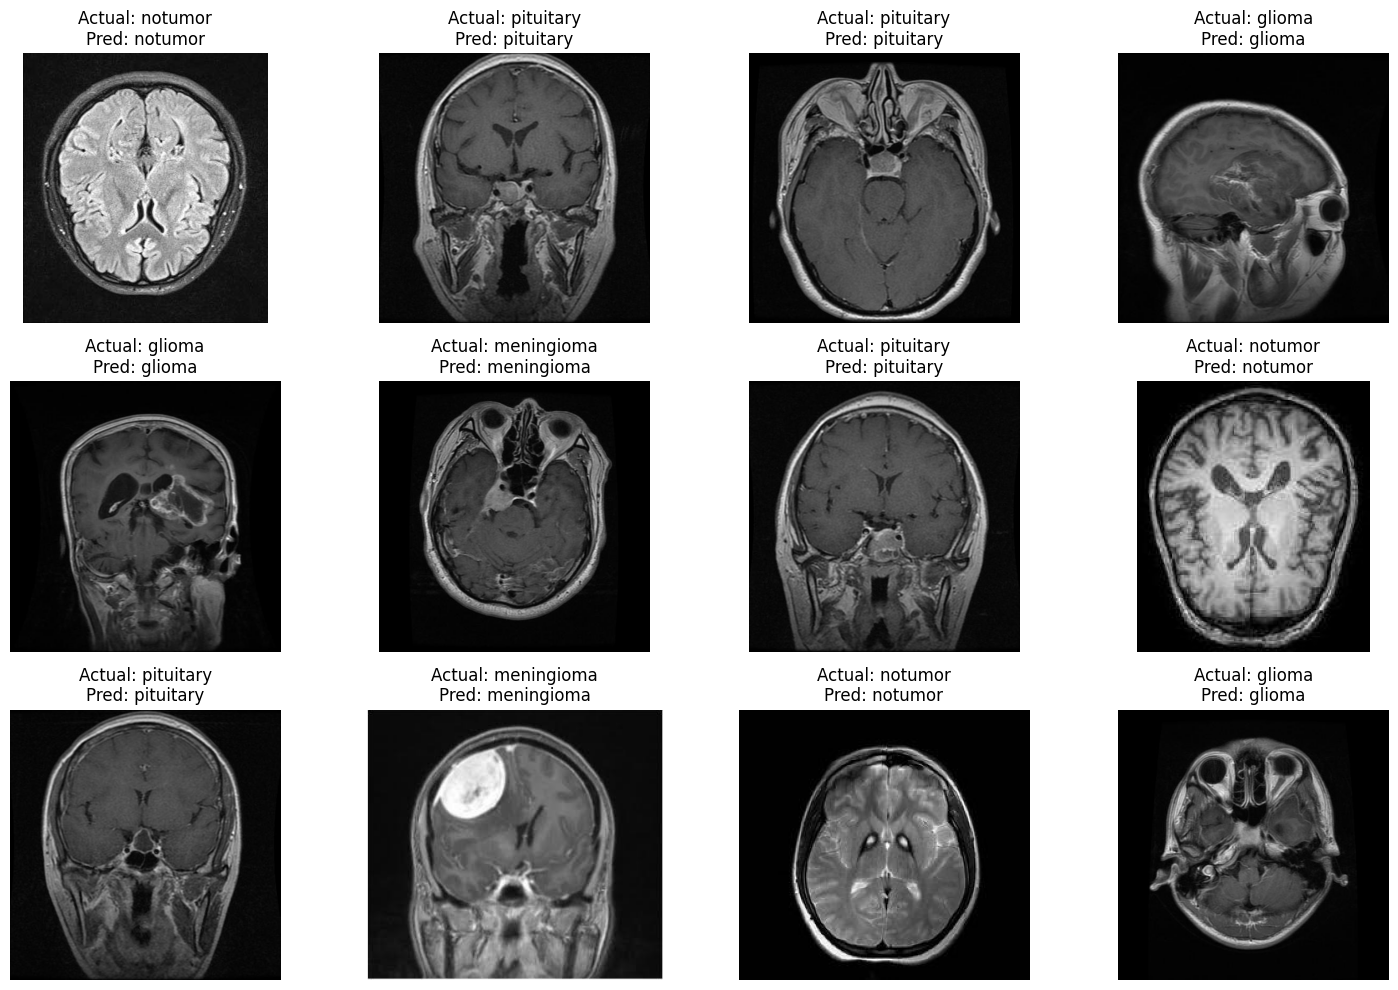

In [21]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

class_names = list(test_generator.class_indices.keys())


def show_random_predictions(n=8):
    all_images = []
    for category in class_names:
        category_path = os.path.join(test_dir, category)
        image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        all_images.extend([(img, category) for img in image_files])


    random_samples = random.sample(all_images, n)

    plt.figure(figsize=(15, 10))
    for i, (img_path, actual_class) in enumerate(random_samples):
        processed_img = load_and_preprocess_image(img_path)
        predictions = model.predict(processed_img, verbose=0)
        predicted_class_index = np.argmax(predictions)
        predicted_class_name = class_names[predicted_class_index]

        img_display = cv2.imread(img_path)
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

        plt.subplot(int(np.ceil(n/4)), 4, i+1)
        plt.imshow(img_display)
        plt.title(f"Actual: {actual_class}\nPred: {predicted_class_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_random_predictions(12)


In [22]:
model.save('brain_tumor_model.h5')

In [23]:
from google.colab import files
files.download('brain_tumor_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>